In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

# Tutorial for the Dataset module

The main object to deal with (one or several) calculations is the Dataset class. Here we discuss some explicit examples to describe the usage and the main features of the package.

## Perform a convergence analysis for the gs energy of Silicon

We discuss how to perform a convergence analysis for the determination of the number of k-points and the cut-off energy that provides _converged_ results for the gs of Silicon using QE.

Define the dataset and specify the type of pre_processing function

In [7]:
si_gs = D.Dataset(label='Si gs convergence',run_dir='si_gs',pre_processing='scf')

Define the calculator that will execute the computations

In [9]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Call the pre_processing function, that in this case build the run_dir if it is not already present

In [10]:
si_gs.pre_processing_function()

Append the runs to the dataset. This procedures make usage of the PwIn boject that creates the instance of the input for QE. The object are written on file only at the level of the run

In [11]:
si_input = I.PwIn()
A = [0.125,0.125,0.125]
B = [-.125,-.125,-.125]

si_input.set_pseudo_dir('../pseudos')
si_input.set_calculation('scf')
si_input.system['force_symmorphic'] = ".true."

si_input.set_occupations('fixed')
si_input.system['ibrav'] = 2
si_input.system['celldm(1)'] = 10.3
si_input.set_atoms_type(1)
si_input.set_atoms_number(2)
si_input.set_atoms_position(pos_type='crystal',pos_list=[['Si',A],['Si',B]])
si_input.atypes = {'Si': [28.086,"Si.pbe-mt_fhi.UPF"]}
si_input.set_convergence_thr(1e-8)

print(si_input)

&control
           verbosity = 'high'
          pseudo_dir = '../pseudos'
         calculation = 'scf'
/&end
&system
    force_symmorphic = .true.
         occupations = 'fixed'
               ibrav = 2
           celldm(1) = 10.3
                ntyp = 1
                 nat = 2
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
  Si   28.086    Si.pbe-mt_fhi.UPF
ATOMIC_POSITIONS { crystal }
 Si   0.1250000000   0.1250000000   0.1250000000
 Si  -0.1250000000  -0.1250000000  -0.1250000000
K_POINTS { automatic }
  1  1  1  0  0  0



Choose the parameters for the convergence test and append the associated runs

In [12]:
kpoints = [2,3,4,5,6] 
ecut = [10,20,30,40,50]

In [13]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        si_input.set_prefix(D.name_from_id(idd))
        si_input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
        si_input.set_energy_cutoff(e)
        si_gs.append_run(id=idd,calculator=code,input=si_input)

In [14]:
print(si_gs.runs[5])

&control
           verbosity = 'high'
          pseudo_dir = '../pseudos'
         calculation = 'scf'
              prefix = 'ecut:10,k:3'
/&end
&system
    force_symmorphic = .true.
         occupations = 'fixed'
               ibrav = 2
           celldm(1) = 10.3
                ntyp = 1
                 nat = 2
             ecutwfc = 10
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
  Si   28.086    Si.pbe-mt_fhi.UPF
ATOMIC_POSITIONS { crystal }
 Si   0.1250000000   0.1250000000   0.1250000000
 Si  -0.1250000000  -0.1250000000  -0.1250000000
K_POINTS { automatic }
  3  3  3  0  0  0



Note tha the prefix associated to each run is built by means of the name_from_id method that create a string from the idd dictionary of the run. This choice is not mandatory but it is an easy way to have a clear association among the runs and the associated names.

The dataset is run as follows:

In [15]:
si_gs.run(post_processing=True)

execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:10,k:2.in > ecut:10,k:2.log
parse file :si_gs/ecut:10,k:2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:20,k:2.in > ecut:20,k:2.log
parse file :si_gs/ecut:20,k:2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:30,k:2.in > ecut:30,k:2.log
parse file :si_gs/ecut:30,k:2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:40,k:2.in > ecut:40,k:2.log
parse file :si_gs/ecut:40,k:2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:50,k:2.in > ecut:50,k:2.log
parse file :si_gs/ecut:50,k:2.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:10,k:3.in > ecut:10,k:3.log
parse file :si_gs/ecut:10,k:3.save/data-file-schema.xml
execute : cd si_gs ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:20,k:3.in > ecut:20,k:3.log

Results can be easily estracted using the fetch_results method of the dataset

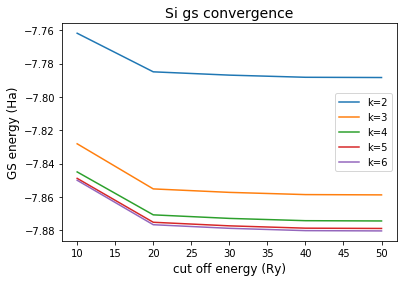

In [16]:
for k in kpoints:
    data=si_gs.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(si_gs.label,size = 14)
plt.xlabel('cut off energy (Ry)',size=12)
plt.ylabel('GS energy (Ha)',size = 12)
plt.legend()
plt.show()

On the basis of this analysis with identify the scf converged parameters that will be used as input for nscf ones

In [17]:
k_conv = 4
ecut_conv = 50

All the results are written in the .results member of the dataset. This is a dictionary in wich all the post_processing are stored, the key represent the position of the study specified in the .ids list

In [18]:
si_gs.results

{0: <qepppy.qe.pw_out.pw_out at 0x7f0f229eff98>,
 1: <qepppy.qe.pw_out.pw_out at 0x7f0f224556a0>,
 2: <qepppy.qe.pw_out.pw_out at 0x7f0f223def28>,
 3: <qepppy.qe.pw_out.pw_out at 0x7f0f223c8fd0>,
 4: <qepppy.qe.pw_out.pw_out at 0x7f0f223dee80>,
 5: <qepppy.qe.pw_out.pw_out at 0x7f0f223e9e48>,
 6: <qepppy.qe.pw_out.pw_out at 0x7f0f22455828>,
 7: <qepppy.qe.pw_out.pw_out at 0x7f0f224557f0>,
 8: <qepppy.qe.pw_out.pw_out at 0x7f0f22375a90>,
 9: <qepppy.qe.pw_out.pw_out at 0x7f0f223bbda0>,
 10: <qepppy.qe.pw_out.pw_out at 0x7f0f22382898>,
 11: <qepppy.qe.pw_out.pw_out at 0x7f0f22396400>,
 12: <qepppy.qe.pw_out.pw_out at 0x7f0f223de978>,
 13: <qepppy.qe.pw_out.pw_out at 0x7f0f223b1358>,
 14: <qepppy.qe.pw_out.pw_out at 0x7f0f2233bf28>,
 15: <qepppy.qe.pw_out.pw_out at 0x7f0f22353cc0>,
 16: <qepppy.qe.pw_out.pw_out at 0x7f0f223e9208>,
 17: <qepppy.qe.pw_out.pw_out at 0x7f0f2245dda0>,
 18: <qepppy.qe.pw_out.pw_out at 0x7f0f222fda20>,
 19: <qepppy.qe.pw_out.pw_out at 0x7f0f22382c18>,
 20: <qepp

In [19]:
si_gs.ids

[{'k': 2, 'ecut': 10},
 {'k': 2, 'ecut': 20},
 {'k': 2, 'ecut': 30},
 {'k': 2, 'ecut': 40},
 {'k': 2, 'ecut': 50},
 {'k': 3, 'ecut': 10},
 {'k': 3, 'ecut': 20},
 {'k': 3, 'ecut': 30},
 {'k': 3, 'ecut': 40},
 {'k': 3, 'ecut': 50},
 {'k': 4, 'ecut': 10},
 {'k': 4, 'ecut': 20},
 {'k': 4, 'ecut': 30},
 {'k': 4, 'ecut': 40},
 {'k': 4, 'ecut': 50},
 {'k': 5, 'ecut': 10},
 {'k': 5, 'ecut': 20},
 {'k': 5, 'ecut': 30},
 {'k': 5, 'ecut': 40},
 {'k': 5, 'ecut': 50},
 {'k': 6, 'ecut': 10},
 {'k': 6, 'ecut': 20},
 {'k': 6, 'ecut': 30},
 {'k': 6, 'ecut': 40},
 {'k': 6, 'ecut': 50}]

A lot of quantities can be extracted from results, for instance

In [20]:
result = si_gs.results[0]

In [21]:
result.E_tot #total energy in Hartree

-7.761788836295096

In [22]:
result.alat #atomic units = angstrom/0.529177211

10.3

In [23]:
result.atoms_coord_cart # in which units ?????

array([[-1.2875,  1.2875,  1.2875],
       [ 1.2875, -1.2875, -1.2875]])

No handles with labels found to put in legend.


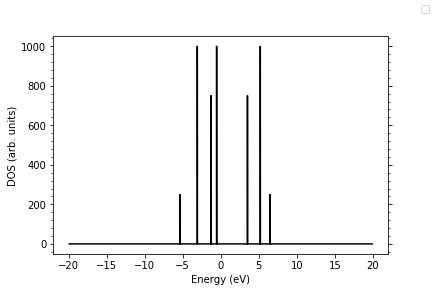

array([[-20.   ,   0.   ],
       [-19.999,   0.   ],
       [-19.998,   0.   ],
       ...,
       [ 19.998,   0.   ],
       [ 19.999,   0.   ],
       [ 20.   ,   0.   ]])

In [24]:
#pFile : option to enable/disable file save
#fname : output file name
result.density_of_states(pFile=False)

## Perform a sef of nscf computations for Silicon

We illustrate the usage of the dataset class to perform nscf computations using QE. In this case the pre_processing function performs different operations since the .save folder of the scf computation used as input has to be copied in the run_dir of the nscf dataset. 

In [31]:
si_nscf = D.Dataset(label='Si nscf',run_dir='si_nscf',pre_processing='nscf')

Define the calculator that will execute the computations

In [32]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Add some runs to the nscf dataset

In [33]:
nscf_kpoints = [4,5,6]

In [34]:
si_input.set_calculation('nscf')
si_input.set_num_bands(10)

for k in nscf_kpoints:
    idd = {'k' : k} 
    si_input.set_prefix(D.name_from_id(idd))
    si_input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
    si_input.set_energy_cutoff(ecut_conv)
    si_nscf.append_run(id=idd,calculator=code,input=si_input)

In [35]:
si_nscf.ids

[{'k': 4}, {'k': 5}, {'k': 6}]

Call the pre_processing function, that in this case build the run_dir if it is not already present

In [36]:
si_nscf.pre_processing_function(source_dir='si_gs/ecut:50,k:4.save')

Create folder si_nscf
execute :  cp -r si_gs/ecut:50,k:4.save si_nscf/k:4.save
execute :  cp -r si_gs/ecut:50,k:4.save si_nscf/k:5.save
execute :  cp -r si_gs/ecut:50,k:4.save si_nscf/k:6.save


Now the dataset can be run and the post_processing parse the output as in the scf case

In [37]:
si_nscf.run()

execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k:4.in > k:4.log
parse file :si_nscf/k:4.save/data-file-schema.xml
execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k:5.in > k:5.log
parse file :si_nscf/k:5.save/data-file-schema.xml
execute : cd si_nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp k:6.in > k:6.log
parse file :si_nscf/k:6.save/data-file-schema.xml


## Perform a set of Hartree-Fock computations with Yambo

Dataset can be used to organize Yambo computation in an analogous way of the QE ones. The differences are represented by the usage of YamboIn to build the input files, the usage of YamboCalculator to run the computations and by the pre_processing function.

In [20]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 4',executable='yambo',verbose=True,skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 4 yambo


In [21]:
yambo_hf = D.Dataset(label='Hatree-Fock',run_dir='yambo_hf',pre_processing='yambo')

In this case the pre_processing function _has to be_ called before appending the runs because the YamboIn class neeeds the SAVE folder to init the input object.

The dataset make usage of __one__ nscf computation to build the SAVE folder that is used in all the runs

In [22]:
source = 'si_nscf/k:6.save'

In [23]:
yambo_hf.pre_processing_function(source_dir=source)

execute :  cd si_nscf/k:6.save;p2y
execute :  cp -r si_nscf/k:6.save/SAVE yambo_hf
execute :  cd yambo_hf;OMP_NUM_THREADS=1 yambo


In [ ]:
# se trova gia la SAVE folder si blocca....da sistemare....

Now the runs can be appended to the dataset. For instance we perform parametric runs in terms of the EXXRLvcs parameter that expresses the energy cutoff in the number of g-components of G0

In [8]:
exx_values = [2.,3.,4.] #in Hartree

In [10]:
yambo_in = I.YamboIn('yambo -x -V rl',folder=yambo_hf.run_dir)

for ex in exx_values:
    idd = {'EXXRLvcs' : ex} 
    yambo_in['EXXRLvcs'] = [1000.0*ex,'mHa']
    yambo_hf.append_run(id=idd,calculator=code,input=yambo_in)  

In [18]:
yambo_hf.ids

[{'EXXRLvcs': 2.0}, {'EXXRLvcs': 3.0}, {'EXXRLvcs': 4.0}]

In [19]:
print(yambo_hf.runs[0])

HF_and_locXC
FFTGvecs = 2133.000000 RL
SE_Threads = 0.000000e+00 
EXXRLvcs = 2000.000000 mHa
% QPkrange
 1 | 32 | 1 | 10 |   
%



In [16]:
yambo_hf.run()

execute : cd yambo_hf ; OMP_NUM_THREADS=1 mpirun -np 4 yambo -F EXXRLvcs:2.0.in -J EXXRLvcs:2.0 -C EXXRLvcs:2.0
output in :  yambo_hf/EXXRLvcs:2.0/o-EXXRLvcs:2.0.hf
skip the computation for : yambo_hf/EXXRLvcs:2.0/o-EXXRLvcs:2.0.hf
output in :  yambo_hf/EXXRLvcs:2.0/o-EXXRLvcs:2.0.hf
skip the computation for : yambo_hf/EXXRLvcs:2.0/o-EXXRLvcs:2.0.hf
output in :  yambo_hf/EXXRLvcs:2.0/o-EXXRLvcs:2.0.hf


In [ ]:
# sembra che provi a ripetere sempre il primo run...sistemare

In [ ]:
################################################

## InputFiles module :  construction of the pw input file

The Inputs module contains the PwIn class that allows us to built the input file of QuantumESPRESSO. 
The constructor of the class builds the input object, the member of the class can be given and modified both using specific methods and/or by direct setting. 

Here we provide, as an example, the building of the input for Graphene:

In [2]:
input = I.PwIn()

In [3]:
k = 6
ecut = 80
a0 = 1.42
planeSep  = 10.0
A = [0.,0.,0.]
B = [0.,a0,0.]
a1 = [a0*np.sqrt(3),0.,0.]
a2 = [a0*np.sqrt(3)/2,a0*3./2,0.]
a3 = [0.,0.,planeSep]

input.set_calculation('scf')
input.set_pseudo_dir('../pseudos')
input.set_prefix('data')
input.system['ibrav'] = 0
input.cell_parameters =[a1,a2,a3]
input.set_atoms_type(1)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='angstrom',pos_list=[['C',A],['C',B]])
input.atypes = {'C': [12.011,'C_pbe-20082014.UPF']}
input.set_convergence_thr(1e-8)
input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
input.set_energy_cutoff(ecut)

print(input)

&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



The input object can be written on file using the write method of PwIn

In [5]:
test_dir = 'test_dir'
if not os.path.isdir(test_dir): os.mkdir(test_dir)

In [6]:
input.write(test_dir+'/'+'input.in')

This class allows us also to create an instance of PwIn starting from an existing file

In [7]:
input2 = I.PwIn(test_dir+'/'+'input.in')
print(input2)

&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



## Calculators module : a calculator object for QuantumESPRESSO

Initialize the calculator

In [8]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Specifies the input object, the name of the file and the run_dir, if post_processing is True the .run returns an instance of the pw_out method of qepppy and contains the results of the computation

In [9]:
results = code.run(input=input,name='test',run_dir='pw_run',post_processing=True)

execute : cd pw_run ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp test.in > test.log


Extract the total energy (in Hartree)

In [10]:
results.E_tot

-11.40037440619968

A lot of quantities can be extracted from results, for instance

In [11]:
results.alat #atomic units = angstrom/0.529177211

4.647804377769

In [12]:
results.atoms_coord_cart # in which units ?????

array([[0.        , 0.        , 0.        ],
       [0.        , 2.68341111, 0.        ]])

No handles with labels found to put in legend.


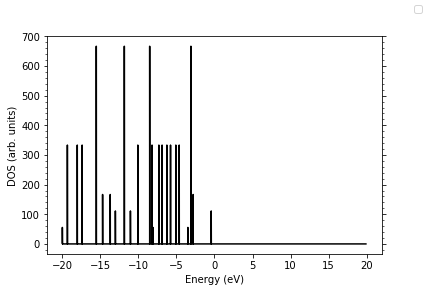

array([[-20.   ,   0.   ],
       [-19.999,   0.   ],
       [-19.998,   0.   ],
       ...,
       [ 19.998,   0.   ],
       [ 19.999,   0.   ],
       [ 20.   ,   0.   ]])

In [12]:
#pFile : option to enable/disable file save
#fname : output file name
results.density_of_states(pFile=False)

## InputFiles module :  construction of the Yambo input file

To build the input file the SAVE folder is needed by Yambo, so we use the yambo_test folder where a SAVE directory has been copied.

The approach used to deal with yambo input files is to call yamboIn with the specific run level. Yambo build a base input file that calls 'yambo.in'. The parameters of the input can be set and the updated file can be written on disk with its specific name.

In [36]:
y = I.YamboIn('yambo -x -V rl',folder='yambo_test')
y['EXXRLvcs'] = [1000.0*20,'mHa']
krange = y['QPkrange'][0][:2]
kbandrange = krange + [1,10]
y['QPkrange'] = [kbandrange,'']
print(y)

HF_and_locXC
FFTGvecs = 941.000000 RL
SE_Threads = 0.000000e+00 
EXXRLvcs = 20000.000000 mHa
% QPkrange
 1 | 4 | 1 | 10 |   
%



## Calculators module : a calculator object for Yambo

The usage of YamboCalculator assumes that the SAVE folder built by p2y is present in the run_dir and that yambo (without argument) has been executed in the folder that contains SAVE to generate r_setup. 

In [26]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 4',executable='yambo',verbose=True,skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 4 yambo


In [27]:
results = code.run(input=y,name='test',run_dir='yambo_test',post_processing=True)

execute : cd yambo_test ; OMP_NUM_THREADS=1 mpirun -np 4 yambo -F test.in -J test -C test
output in :  yambo_test/test/o-test.hf


In [28]:
results.keys()

dict_keys(['K-point', 'Band', 'Eo', 'Ehf', 'DFT', 'HF'])

## Dataset module : how to manage several calculations in QE

Show the functionality of this module by performing a convergence test for the ground state in function of the number of k-points and of the energy cutoff

In [13]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [14]:
study = D.Dataset(label='gs_convergence',run_dir='gs_convergence')

In [15]:
kpoints = [3,6,9,12]
ecut = [40,60,80,100]

In [16]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.set_prefix(D.name_from_id(idd))
        input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
        input.set_energy_cutoff(e)
        study.append_run(id=idd,calculator=code,input=input)

The paramaters of the dataset are given as follows, for instance

In [17]:
print(study.names)
print(study.ids)
print(study.calculators)
print(study.runs[3])

['ecut:40,k:3', 'ecut:60,k:3', 'ecut:80,k:3', 'ecut:100,k:3', 'ecut:40,k:6', 'ecut:60,k:6', 'ecut:80,k:6', 'ecut:100,k:6', 'ecut:40,k:9', 'ecut:60,k:9', 'ecut:80,k:9', 'ecut:100,k:9', 'ecut:40,k:12', 'ecut:60,k:12', 'ecut:80,k:12', 'ecut:100,k:12']
[{'k': 3, 'ecut': 40}, {'k': 3, 'ecut': 60}, {'k': 3, 'ecut': 80}, {'k': 3, 'ecut': 100}, {'k': 6, 'ecut': 40}, {'k': 6, 'ecut': 60}, {'k': 6, 'ecut': 80}, {'k': 6, 'ecut': 100}, {'k': 9, 'ecut': 40}, {'k': 9, 'ecut': 60}, {'k': 9, 'ecut': 80}, {'k': 9, 'ecut': 100}, {'k': 12, 'ecut': 40}, {'k': 12, 'ecut': 60}, {'k': 12, 'ecut': 80}, {'k': 12, 'ecut': 100}]
[{'calc': <mppi.Calculators.Calculators.QeCalculator object at 0x7fdae677cd68>, 'runs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}]
&control
           verbosity = 'high'
         calculation = 'scf'
          pseudo_dir = '../pseudos'
              prefix = 'ecut:100,k:3'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             e

In [18]:
results = study.run(post_processing=True)

skip the computation for : ecut:40,k:3.log
skip the computation for : ecut:60,k:3.log
skip the computation for : ecut:80,k:3.log
skip the computation for : ecut:100,k:3.log
skip the computation for : ecut:40,k:6.log
skip the computation for : ecut:60,k:6.log
skip the computation for : ecut:80,k:6.log
skip the computation for : ecut:100,k:6.log
skip the computation for : ecut:40,k:9.log
skip the computation for : ecut:60,k:9.log
skip the computation for : ecut:80,k:9.log
skip the computation for : ecut:100,k:9.log
skip the computation for : ecut:40,k:12.log
skip the computation for : ecut:60,k:12.log
skip the computation for : ecut:80,k:12.log
skip the computation for : ecut:100,k:12.log


## Dataset module : post_processing of data

All the results of the dataset are stored in study.results as a dictionary

In [20]:
study.results

{0: <qepppy.qe.pw_out.pw_out at 0x7fdae67151d0>,
 1: <qepppy.qe.pw_out.pw_out at 0x7fdae6670f60>,
 2: <qepppy.qe.pw_out.pw_out at 0x7fdae66c3ef0>,
 3: <qepppy.qe.pw_out.pw_out at 0x7fdae6670550>,
 4: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4048>,
 5: <qepppy.qe.pw_out.pw_out at 0x7fdae66c39e8>,
 6: <qepppy.qe.pw_out.pw_out at 0x7fdae6715208>,
 7: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4c88>,
 8: <qepppy.qe.pw_out.pw_out at 0x7fdae679a1d0>,
 9: <qepppy.qe.pw_out.pw_out at 0x7fdae66d2d30>,
 10: <qepppy.qe.pw_out.pw_out at 0x7fdae6699eb8>,
 11: <qepppy.qe.pw_out.pw_out at 0x7fdae87b3b70>,
 12: <qepppy.qe.pw_out.pw_out at 0x7fdae66e4ba8>,
 13: <qepppy.qe.pw_out.pw_out at 0x7fdae6670eb8>,
 14: <qepppy.qe.pw_out.pw_out at 0x7fdae66d21d0>,
 15: <qepppy.qe.pw_out.pw_out at 0x7fdae6641438>}

To identify the correspondence between the element of study.results and the id, we have to look the position of the study in the ids list and select the associated element of the results dictionary

In [21]:
study.ids

[{'k': 3, 'ecut': 40},
 {'k': 3, 'ecut': 60},
 {'k': 3, 'ecut': 80},
 {'k': 3, 'ecut': 100},
 {'k': 6, 'ecut': 40},
 {'k': 6, 'ecut': 60},
 {'k': 6, 'ecut': 80},
 {'k': 6, 'ecut': 100},
 {'k': 9, 'ecut': 40},
 {'k': 9, 'ecut': 60},
 {'k': 9, 'ecut': 80},
 {'k': 9, 'ecut': 100},
 {'k': 12, 'ecut': 40},
 {'k': 12, 'ecut': 60},
 {'k': 12, 'ecut': 80},
 {'k': 12, 'ecut': 100}]

In [28]:
# For instance extract the total energy in two cases and compare with the values in the log files
# to check that the extraction procedure is correct
# energy of {'k': 3, 'ecut': 40}
print(2*study.results[0].E_tot)
# energy of {'k': 12, 'ecut': 80}
print(2*study.results[14].E_tot)

-22.70184777668358
-22.80443990263086


The fetch_results method of Dataset can be used to extract a quantity, for instance the total energy E_tot,for a subset of the Dataset elements specified by a dictionary, as follows

In [12]:
data=study.fetch_results(id={'ecut': 40},attribute='E_tot')
data

[-11.35092388834179,
 -11.37186320611442,
 -11.37341431882221,
 -11.37382494507814]

It can also be used to plot the usual convergence analysis

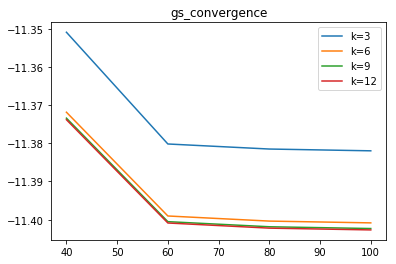

In [13]:
for k in kpoints:
    data=study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(study.label)
plt.legend()
plt.show()
    

## Dataset module : nscf pre_processing function in QE

In some cases it is useful to perform some preliminary operations before running a computation. For instance before performing a QE nscf computation we need copy of the scf .save folder in the appropriate location

For this reason we introduce a pre_processing function that perform the needed operations using the parameters passed to constructor of the dataset object. 

We discuss this functionality by considering a dataset of nscf computations peformed using a subset of values of kpoints and ecut previously defined. 

In [40]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [41]:
nscf_study = D.Dataset(label='nscf_analysis',run_dir='nscf',pre_processing='nscf',source_dir='gs_convergence')

The parameters for the pre_processing are stored in the kwargs elements of the class

In [46]:
nscf_study.kwargs

{'pre_processing': 'nscf', 'source_dir': 'gs_convergence'}

In [43]:
nscf_kpoints = [3,6,9]
nscf_ecut = 100

Append the chosen nscf computations to the dataset, note that the prefix of these computations have to be the same of the scf ones

In [44]:
input.set_calculation('nscf')
input.system['nbnd'] = 16

for k in nscf_kpoints:
    idd = {'k' : k, 'ecut' : nscf_ecut} 
    input.set_prefix(D.name_from_id(idd))
    input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
    input.set_energy_cutoff(nscf_ecut)
    nscf_study.append_run(id=idd,calculator=code,input=input)

In [45]:
nscf_study.run()

nscf save folder already exsists. Save folder NOT COPIED
nscf save folder already exsists. Save folder NOT COPIED
nscf save folder already exsists. Save folder NOT COPIED
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:3.in > ecut:100,k:3.log
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:6.in > ecut:100,k:6.log
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:9.in > ecut:100,k:9.log


COMMENT : With this implementation of the pre_processing function the ids and prefix of the nscf dataset need to have the same structure of the scf ones, maybe this could be too restrictive in some cases....

## Dataset module : pre_processing function in Yambo

The construction of the Yambo input files requires the presence of folder that contains the SAVE folder produced by the action of p2y in a QE .save directory. 

This operation must be performed before appending the computations to a dataset because at this level the instance of YamboIn are passed to the append_run method. It is convenient to define a pre_processing function that is called _before_ the append_run method. 

The pre_processing function performs the following operations : 
* runs p2y in the source_dir and create the SAVE folder
* create the run_dir if it does not exists
* copy the SAVE folder in the run_dir and executes yambo (without arguments) to build the r_setup

To show the functionality of the pre_processing function for Yambo we build a Yambo dataset that takes as input the nscf computations (or a part of) given in the nscf folder.

In [29]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 4',executable='yambo',verbose=True,skip=True)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 4 yambo


Suppose that we want to append computations for the values

In [32]:
yambo_kpoints = [6,9]
yambo_ecut = 100

Un dataset di Yambo vive in un run_dir dentro la quale c'è una SAVE qui un dataset ha un solo calcolo nscf di riferimento. Quindi, ad esempio scelgo k=6

In [37]:
run_dir = 'yambo_k6'
yambo_study = D.Dataset(label='k6',run_dir='yambo_k6',pre_processing='yambo',source_dir='nscf/ecut:100,k:6.save')

In [35]:
y = I.YamboIn('yambo -x -V rl',folder=fold)
y['EXXRLvcs'] = [1000.0*20,'mHa']
#krange = y['QPkrange'][0][:2]
#kbandrange = krange + [1,10]
#y['QPkrange'] = [kbandrange,'']
#print(y)

HF_and_locXC
FFTGvecs = 941.000000 RL
SE_Threads = 0.000000e+00 
EXXRLvcs = 20000.000000 mHa
% QPkrange
 1 | 4 | 1 | 10 |   
%



In [ ]:
for ex in [2.,3.,4.]:
    idd = {'EXXRLvcs' : ex} 
    y['EXXRLvcs'] = [1000.0*20,'mHa']
    input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
    input.set_energy_cutoff(nscf_ecut)
    nscf_study.append_run(id=idd,calculator=code,input=input)

cosi non si puo fare!!!! se non c'è la save folder YamboIn non puo creare l'input